# Classify the tiles using pretrained tile2vec
In this notebook we are going to measure the performance of classifier on EuroSATallbands dataset.

We will use model weights that are in the `/storage/tile2vec/models/`. Firstly we need to load the weights and create the embeddings of the tiles using our pretrained model.

## Load the model

Firstly we need to load the pretrained model. We use a simple function that loads the checkpoints.

In [1]:
import os
import torch
from pathlib import Path
import sys
sys.path.append("..")

from src.tilenet import make_tilenet


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()

def load_model(model_filepath, bands = 13, z_dim = 512):
    
    model_dir = Path('/storage/tile2vec/models/limited_bands_models')
    model_fn = model_dir / model_filepath # specify which model weights are to be loaded
    
    bands = bands # number of bands in the input data - should matche the model
    z_dim = z_dim # output dimension of the last layer of the encoder - should match the model


    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    cuda = torch.cuda.is_available()


    tilenet = make_tilenet(in_channels=bands, z_dim=z_dim) 
    if cuda: 
        tilenet.cuda()
        
    print("Model filepath: ", model_fn)

    checkpoint = torch.load(model_fn)
    tilenet.load_state_dict(checkpoint)
    tilenet.eval()
    print("Model succesfully loaded")
    return tilenet

In [2]:
tilenet = load_model(Path('Tile2Vec_color_infrated.ckpt'), bands=3)

Model filepath:  /storage/tile2vec/models/limited_bands_models/Tile2Vec_color_infrated.ckpt
Model succesfully loaded


## load the bare files and organize them into a dataframe

We need to load the files to perform evaluation. To evaluate performance of our trained unsupervised model, we need to perform a simple inference (forward pass) on the tiles and then create a classfier. Here we will use random forests and logistic regression. 

The classifier models will be trained using the embeddings from joined test and validation dataset. Because our dataset is quite well-balanced, our metric is set to be the accuracy measured using the 5-fold crossvalidation.

In [3]:
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from pathlib import Path
from src.data_utils import clip_and_scale_image

In [4]:
val_df = pd.read_csv("/storage/EuroSATallBands/validation.csv")
n_tiles = len(val_df)
tiles_path = Path("/storage/tile2vec/npy/val")

X_bare_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_val = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_val[index] = clip_and_scale_image(tile, img_type="landsat").flatten()
    X_bare_val[index] = tile.flatten()
    
y_val = val_df["Label"]

test_df = pd.read_csv("/storage/EuroSATallBands/test.csv")
n_tiles = len(test_df)
tiles_path = Path("/storage/tile2vec/npy/test")

X_bare_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_test = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_test[index] = clip_and_scale_image(tile, img_type="landsat").flatten()
    X_bare_test[index] = tile.flatten()
    
y_test = test_df["Label"]


train_df = pd.read_csv("/storage/EuroSATallBands/train.csv")
n_tiles = len(train_df)
tiles_path = Path("/storage/tile2vec/npy/train")

X_bare_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)
X_norm_train = np.zeros((n_tiles, 64 * 64 * 13), dtype=np.float32)

for index in tqdm(range(n_tiles)):
    tile = np.load(tiles_path / f"{index}.npy")
    X_norm_train[index] =  clip_and_scale_image(tile, img_type="sentinel").flatten()

    X_bare_train[index] = tile.flatten()
    
y_train = train_df["Label"]

  0%|          | 0/5519 [00:00<?, ?it/s]

100%|██████████| 19317/19317 [00:11<00:00, 1695.42it/s]


In [5]:
y_train = train_df["Label"]
y_validation = val_df["Label"]
y_test = test_df["Label"]

In [6]:
X_norm_valtest = np.concatenate((X_norm_val, X_norm_test), axis=0)
y_valtest = np.concatenate((y_validation, y_test), axis=0)

We also want to compare our model with different methods of dimentionality reduction. Therefore we create variables to evaluate performance of different methods. In the code above we create 6 matrices, two for each part of our data. Each matrix contains observations from sets. For instance, X_*_train contains images as rows, which are flattened to a row-vector. Each collum contains information about pixel on a specific position in the image.

## Embeddings
Below there is a function that creates embeddings from the provided path and the model.

In [7]:

def create_embeddings_tile2vec(tilenet, 
                               df_filepath: str | Path, 
                               tiles_path: str | Path, 
                               img_type: str = "sentinel", 
                               bands: int = 13, 
                               z_dim: int = 512):
    """
    function creates matrix X and y containing embeddings and labels, loads the tiles from directory `tiles_path`
    """
    df_filepath = Path(df_filepath)
    tiles_path = Path(tiles_path)
    df = pd.read_csv(df_filepath)
    n_tiles = len(df)    
    
    X = np.zeros((n_tiles, z_dim))
    
    t0 = time()
    # this solution to iterate over examples is very suboptimal, one should use torch dataset
    for index in tqdm(range(n_tiles)):
        # read the tile from provided filepath
        
        tile = np.load(tiles_path / f"{index}.npy")  
        tile = clip_and_scale_image(tile, img_type=img_type)[:, :bands,:, :]
        tile = torch.from_numpy(tile).float()
        tile = (tile)
        if cuda: 
            tile = tile.cuda()
        z = tilenet.encode(tile)
        if cuda: 
            z = z.cpu()
        z = z.data.numpy()
        
        X[index,:] = z

    t1 = time()
    print('Embedded {} tiles: {:0.3f}s'.format(n_tiles, t1-t0))
    
    y = df['Label'].values
    
    return X, y

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

rf = RandomForestClassifier()

In [9]:
# DO ZMIANY ŻEBY MIEĆ WYNIKI DLA POSZCZEGÓLNYCH LABELI

def compare_results(X, y, model, folds = 5, model_name = ""):
    # simple method to evaluate performance of model using cross validation
    if model_name == "":
        model_name = model.__class__.__name__
    
    # CROSS VAL PEWNIE DO ZMIANY
    scores = cross_val_score(model, X, y, cv=folds)
    print("Averaged accuracy for model {}: {:.2f}±{:.2f}%".format(model_name, scores.mean()*100, scores.std()*100))

# Evaluation
Finally we perform tests, each section contains code and results of evaluation - the results and model or method type

## Default model scaling
Here we are going to check the performance of model with no band-specfic scaling

In [12]:
no_clipping = load_model("Tile2Vec_color_infrated.ckpt", bands=3)
X_validation, y_validation = create_embeddings_tile2vec(no_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat", bands=3)
X_test, y_test = create_embeddings_tile2vec(no_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', "landsat", bands=3)

Model filepath:  /storage/tile2vec/models/limited_bands_models/Tile2Vec_color_infrated.ckpt
Model succesfully loaded


100%|██████████| 5519/5519 [00:18<00:00, 293.74it/s]


Embedded 5519 tiles: 18.791s


100%|██████████| 2759/2759 [00:08<00:00, 307.36it/s]

Embedded 2759 tiles: 8.979s


In [13]:
X = np.concatenate((X_validation, X_test), axis=0)  
y = np.concatenate((y_validation, y_test), axis=0)

In [14]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 48.31±0.69%


In [15]:
compare_results(X, y, lr, folds = 5)

Averaged accuracy for model LogisticRegression: 13.02±0.03%


Text(0.5, 1.0, 'Heatmap of predictions')

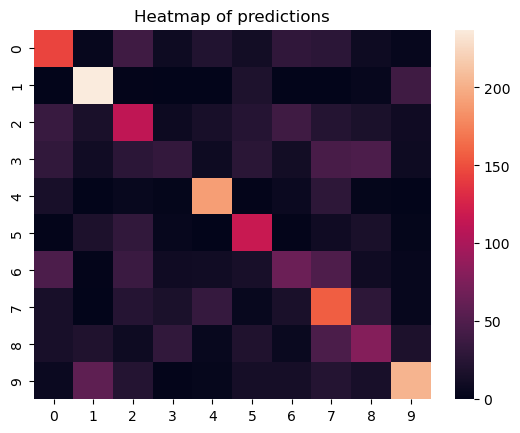

In [16]:
rf.fit(X_validation, y_validation)
y_pred = rf.predict(X_test)


sns.heatmap(confusion_matrix(y_test, y_pred))
plt.title("Heatmap of predictions")

## Custom outlier clipping
Here we evaluate performance of model with band normalization based on IQR on train set

In [20]:
custom_clipping = load_model("Tile2Vec_color_infrated.ckpt", bands=3)
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', bands=3)
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', bands=3)

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

Model filepath:  /storage/tile2vec/models/limited_bands_models/Tile2Vec_color_infrated.ckpt
Model succesfully loaded


100%|██████████| 5519/5519 [00:19<00:00, 282.27it/s]


Embedded 5519 tiles: 19.555s


100%|██████████| 2759/2759 [00:09<00:00, 293.28it/s]


Embedded 2759 tiles: 9.410s
Averaged accuracy for model RandomForestClassifier: 13.02±0.03%
Averaged accuracy for model LogisticRegression: 13.02±0.03%


Text(0.5, 1.0, 'Heatmap of predictions')

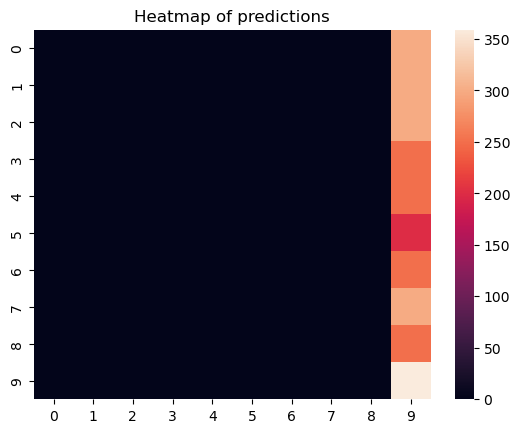

In [21]:
rf.fit(X_validation, y_validation)
y_pred = rf.predict(X_test)


sns.heatmap(confusion_matrix(y_test, y_pred))
plt.title("Heatmap of predictions")

## PCA 
Instead of some fancy tilenet base encoding we will try to use pca to create embeddings - maybe using the simple dimentionality reduction method we will obtain comparable results

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)
pca.fit(X_norm_train)

PCA(n_components=512)

In [23]:
X_pca = pca.transform(X_norm_valtest)

In [24]:
compare_results(X_pca, y_valtest, rf, folds = 5)
compare_results(X_pca, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 75.57±0.88%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Averaged accuracy for model LogisticRegression: 69.56±1.06%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
import pickle

with open("/storage/tile2vec/models/pca.pkl", "wb") as p:
    pickle.dump(pca, p)

PermissionError: [Errno 13] Permission denied: '/storage/tile2vec/models/pca.pkl'

## FastICA

In [26]:
from sklearn.decomposition import FastICA

fastica = FastICA(n_components=512)

fastica.fit(X_norm_train)

/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


FastICA(n_components=512)

In [27]:
X_fastica = fastica.transform(X_norm_valtest)

compare_results(X_fastica, y_valtest, rf, folds = 5)
compare_results(X_fastica, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 76.69±0.78%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Averaged accuracy for model LogisticRegression: 64.42±1.03%


/home/natalia/.conda/envs/tile2vec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:

with open("/storage/tile2vec/models/fastica.pkl", "wb") as p:
    pickle.dump(fastica, p)

## KMeans

KMeans with 10 clusters

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10)

kmeans.fit(X_norm_train, y_train)

X_kmeans = kmeans.transform(X_norm_valtest)

In [41]:
with open("/storage/tile2vec/models/kmeans.pkl", "wb") as p:
    pickle.dump(kmeans, p)

In [35]:
compare_results(X_kmeans, y_valtest, rf, folds = 5)
compare_results(X_kmeans, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 75.15±0.82%
Averaged accuracy for model LogisticRegression: 75.19±0.68%


## No embeddings

In [42]:
compare_results(X_norm_valtest, y_valtest, rf, folds = 5)
compare_results(X_norm_valtest, y_valtest, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 79.71±1.05%
Averaged accuracy for model LogisticRegression: 79.72±1.42%


## Pretrained ResNet18

In [53]:
from src.resnet import ResNet18


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda = torch.cuda.is_available()


og_tilenet = ResNet18()
if cuda: 
    og_tilenet.cuda()
    

checkpoint = torch.load("models/naip_trained.ckpt")
og_tilenet.load_state_dict(checkpoint)
og_tilenet.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [57]:
X_validation, y_validation = create_embeddings_tile2vec(og_tilenet, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', bands=4)
X_test, y_test = create_embeddings_tile2vec(og_tilenet, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test', bands=4)

100%|██████████| 5519/5519 [00:59<00:00, 92.09it/s] 


Embedded 5519 tiles: 59.936s


100%|██████████| 2759/2759 [00:29<00:00, 92.85it/s]

Embedded 2759 tiles: 29.718s


In [58]:

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

Averaged accuracy for model RandomForestClassifier: 45.80±1.50%
Averaged accuracy for model LogisticRegression: 45.12±1.61%


## Tile size 40

In [12]:
custom_clipping = load_model("TileNet_tile_40.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

/storage/tile2vec/models/TileNet_tile_40.ckpt


100%|██████████| 5519/5519 [00:33<00:00, 162.93it/s]


Embedded 5519 tiles: 33.877s


100%|██████████| 2759/2759 [00:18<00:00, 150.43it/s]


Embedded 2759 tiles: 18.343s
Averaged accuracy for model RandomForestClassifier: 52.34±4.33%
Averaged accuracy for model LogisticRegression: 51.60±4.23%


## tile size 30

In [13]:
custom_clipping = load_model("TileNet_tile_30.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

/storage/tile2vec/models/TileNet_tile_30.ckpt


100%|██████████| 5519/5519 [00:22<00:00, 248.83it/s]


Embedded 5519 tiles: 22.182s


100%|██████████| 2759/2759 [00:12<00:00, 217.08it/s]


Embedded 2759 tiles: 12.712s
Averaged accuracy for model RandomForestClassifier: 53.66±1.17%
Averaged accuracy for model LogisticRegression: 53.44±1.09%


## tile size 60

In [14]:
custom_clipping = load_model("TileNet_tile_60.ckpt")
X_validation, y_validation = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/validation.csv', '/storage/tile2vec/tif/val', "landsat")
X_test, y_test = create_embeddings_tile2vec(custom_clipping, '/storage/EuroSATallBands/test.csv', '/storage/tile2vec/tif/test')

X = np.concatenate((X_validation, X_test), axis=0)
y = np.concatenate((y_validation, y_test), axis=0)

compare_results(X, y, rf, folds = 5)
compare_results(X, y, lr, folds = 5)

/storage/tile2vec/models/TileNet_tile_60.ckpt


100%|██████████| 5519/5519 [00:17<00:00, 308.33it/s]


Embedded 5519 tiles: 17.901s


100%|██████████| 2759/2759 [00:10<00:00, 256.53it/s]


Embedded 2759 tiles: 10.757s
Averaged accuracy for model RandomForestClassifier: 56.73±0.90%
Averaged accuracy for model LogisticRegression: 56.43±0.97%
